In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot

In [29]:
startup = pd.read_csv('50_Startups.csv')

In [30]:
startup.head(10)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94
5,131876.90,99814.71,362861.36,New York,156991.12
6,134615.46,147198.87,127716.82,California,156122.51
7,130298.13,145530.06,323876.68,Florida,155752.60
8,120542.52,148718.95,311613.29,New York,152211.77
9,123334.88,108679.17,304981.62,California,149759.96


In [31]:
startup.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

In [32]:
startup.rename(columns = {'R&D Spend': 'rd_spend', 'Marketing Spend': 'market_spend', 'Administration': 'admin'}, inplace = True)

In [33]:
startup.columns

Index(['rd_spend', 'admin', 'market_spend', 'State', 'Profit'], dtype='object')

In [34]:
startup.corr()

,rd_spend,admin,market_spend,Profit
rd_spend,1.000000,0.241955,0.724248,0.972900
admin,0.241955,1.000000,-0.032154,0.200717
market_spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


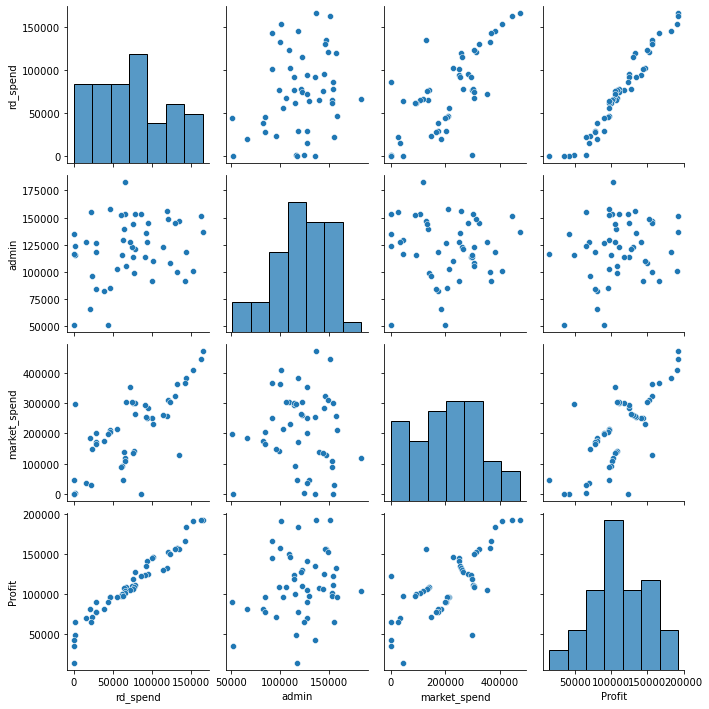

In [35]:
sns.pairplot(startup)

### List of the assumptions:
1. The features should be independent of each others
2. Errors and features are independent of each other
3. Q-Q plotting
4. Homoscedasticity: Variance of errors should be constant
5. Linearity: Y is having linear relation with all features

### 1. The features should be independent of each other:
- Clearly from above we see that rd_spend is dependent with market_spend
- Also admin is not making much difference with Profit

In [36]:
# preparing a basic model
model = smf.ols('Profit~admin+rd_spend+market_spend', data = startup).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Fri, 22 Jul 2022   Prob (F-statistic):           4.53e-30
Time:                        17:54:27   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.012e+04   6572.353      7.626      0.000    3.69e+04    6.34e+04
admin           -0.0268      0.051     -0.526      0.602      -0.130       0.076
rd_spend         0.8057      0.045     17.846      0.000       0.715       0.897
market_spend     0.0272      0.016      1.655      0.105      -0.006       0.060
==============================================================================
Omnibus:                       14.838   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.442
Skew:                          -0.949   Prob(JB):                     2.21e-05
Kurtosis:                       5.586   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- The market_spend and rd_spend are dependent on each other
- Also admin doesn't contribute much to the model(as per the model says with the higher pvalue of admin)
- Lets, plot slr model using all features to predict the target variable

In [37]:
# profit vs admin
# check admin vs profit to make sure to remove admin
admin_pr_model = smf.ols('Profit~admin', data = startup).fit()
print(admin_pr_model.rsquared , round((admin_pr_model.pvalues),3)) # rsqr= 0.04 & pval=0.162

0.04028714077757223 Intercept    0.004
admin        0.162
dtype: float64


In [38]:
# profit vs market_spend
mk_pr_model = smf.ols('Profit~market_spend', data = startup).fit()
print(mk_pr_model.rsquared,round((mk_pr_model.pvalues),3)) # rsqr= 0.56 & pval=0.0

0.5591535746115515 Intercept       0.0
market_spend    0.0
dtype: float64


In [39]:
# profit vs rd_spend
rd_pr_model = smf.ols('Profit~rd_spend',data = startup).fit()
print(rd_pr_model.rsquared , round((rd_pr_model.pvalues),3)) # rsqr= 0.95 & pval=0.0

0.9465353160804393 Intercept    0.0
rd_spend     0.0
dtype: float64


#### Clearly, the rd_spend's contributon to Profit prediction is much more than market_spend's contribution

- We know that market_spend and rd_spend are correlated from correlation matrix and from the pairplot diagram

Another way to see the multi-collinearity between the features is: calculating the **VIF Factor**

In [40]:
admin_r = smf.ols('admin~market_spend+rd_spend',data=startup).fit().rsquared
vif_admin = 1 / (1- admin_r)
vif_admin

1.1750910070550455

In [41]:
market_r = smf.ols('market_spend~admin+rd_spend',data=startup).fit().rsquared
vif_market = 1 / (1- market_r)
vif_market

2.3267732905308773

In [42]:
rd_r = smf.ols('rd_spend~admin+market_spend', data = startup).fit().rsquared
vif_rd = 1 / (1-rd_r)
vif_rd

2.468903069994701

In [43]:
dict_ = {'Variables': ['market_spend', 'rd_spend', 'admin'] , 'VIF': [vif_market , vif_rd , vif_admin]}

In [44]:
VIFframe = pd.DataFrame(dict_)

In [45]:
VIFframe

,Variables,VIF
0,market_spend,2.326773
1,rd_spend,2.468903
2,admin,1.175091


### Market_spend and rd_spend are dependent

In [46]:
admin_rd = smf.ols('Profit~admin+rd_spend', data = startup ).fit()

In [47]:
admin_rd

- Clearly we will use RDSpend and Admin to predict the Profit

In [48]:
round((admin_rd.rsquared),3)

0.948

- Although 94.8 accuracy is good enough, but the pvalue of admin is high, let's create a model with just one feature rd_spend

In [49]:
rd_spend_model = smf.ols('Profit~rd_spend', data= startup).fit()

In [50]:
round((rd_spend_model.rsquared),3)

0.947

### ==============Accuracy:0.948 using rd_spend and admin as features ================